<a href="https://www.kaggle.com/code/abdelwahabkamal/worldcup-22-match-prediction-gradient-boosting-83?scriptVersionId=111102895" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fifaworldranking/fifa_ranking-2022-10-06.csv
/kaggle/input/international-football-results-from-1872-to-2017/shootouts.csv
/kaggle/input/international-football-results-from-1872-to-2017/results.csv


# Data Preprocessing

In [2]:
df =  pd.read_csv("../input/international-football-results-from-1872-to-2017/results.csv")
df["date"] = pd.to_datetime(df["date"])

In [3]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    1
away_score    1
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [4]:
df.dropna(inplace=True)

**the dataset used will be from jan 2020**

In [5]:
df = df[(df["date"] >= "2020-1-1")].reset_index(drop=True)

In [6]:
rank = pd.read_csv("../input/fifaworldranking/fifa_ranking-2022-10-06.csv")

In [7]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2020-1-1")].reset_index(drop=True)

**Some teams in have different names in the ranking's dataset.**

In [8]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

**The merge is made in order to get a dataset FIFA games and its rankings.**

In [9]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

In [10]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [11]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [12]:
df = df_wc_ranked

**create the feature that says which team won and how much points they made at game.**

In [13]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [14]:
df[["result", "home_team_points", "away_team_points"]] = results

**create columns that will help in the creation of the features: ranking difference, points won at the game vs. team faced rank, and goals difference in the game.**

In [15]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [16]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [17]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [18]:
team_stats = home_team.append(away_team)#.sort_values("date")

In [19]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2020-09-03,Germany,1.0,1.0,15.0,8.0,0.0,1602.00,2,7.0,0.125000,1
1,2020-09-03,Ukraine,2.0,1.0,24.0,12.0,0.0,1537.00,0,12.0,0.250000,3
2,2020-09-03,Russia,3.0,1.0,38.0,29.0,0.0,1470.00,0,9.0,0.103448,3
3,2020-09-03,Turkey,0.0,1.0,29.0,52.0,0.0,1494.00,1,-23.0,0.000000,0
4,2020-09-03,Bulgaria,1.0,1.0,59.0,34.0,0.0,1381.00,2,25.0,0.029412,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1962,2022-09-27,Iceland,1.0,1.0,63.0,66.0,0.0,1379.61,2,3.0,0.015152,1
1963,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3
1964,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1
1965,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0


# **Data Processing**

**Now, we have a database ready to create predictive features. They will be:**

1. Mean goals of the team in World Cup Cycle.
2. Mean goals of the team in last 5 games.
3. Mean goals suffered of the team in World Cup Cycle.
4. Mean goals suffered of the team in last 5 games.
5. Mean FIFA Rank that team faced in World Cup Cycle.
6. Mean FIFA Rank that team faced in last 5 games.
7. FIFA Points won at the cycle.
8. FIFA Points won in last 5 games.
9. Mean game points at the Cycle.
10. Mean game points at last 5 games.
11. Mean game points by rank faced at the Cycle.
12. Mean game points by rank faced at last 5 games 

****

In [20]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [21]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [22]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [23]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [24]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [25]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [26]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [27]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

**finds competition of the game.**

In [28]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [29]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [30]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.head()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
0,2020-09-03,Germany,Spain,15.0,8.0,1.0,1.0,2,7.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,2020-09-03,Ukraine,Switzerland,24.0,12.0,2.0,1.0,0,12.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,2020-09-03,Russia,Serbia,38.0,29.0,3.0,1.0,0,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,2020-09-03,Turkey,Hungary,29.0,52.0,0.0,1.0,1,-23.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,2020-09-03,Bulgaria,Republic of Ireland,59.0,34.0,1.0,1.0,2,25.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [31]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                   93
home_goals_mean_l5                93
home_goals_suf_mean               93
home_goals_suf_mean_l5            93
home_rank_mean                    93
home_rank_mean_l5                 93
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  100
away_goals_mean_l5               100
away_goals_suf_mean              100
away_goals_suf_mean_l5           100
away_rank_mean                   100
away_rank_mean_l5                100
away_points_mean                   0
away_points_mean_l5                0
h

In [32]:
base_df_no_fg = base_df.dropna()

In [33]:
df = base_df_no_fg

# Analyzing

In [34]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [35]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [36]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

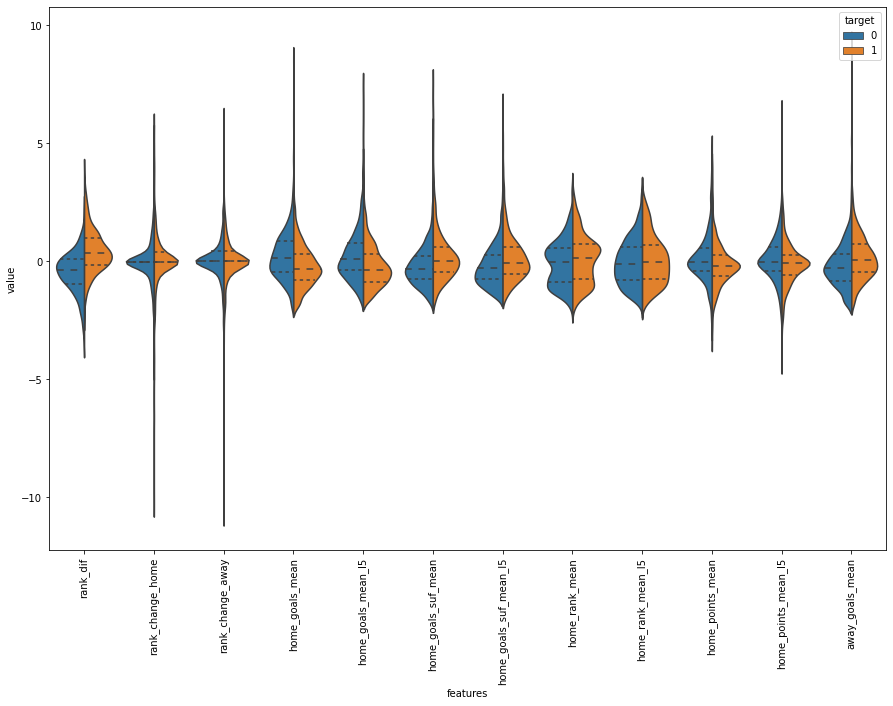

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

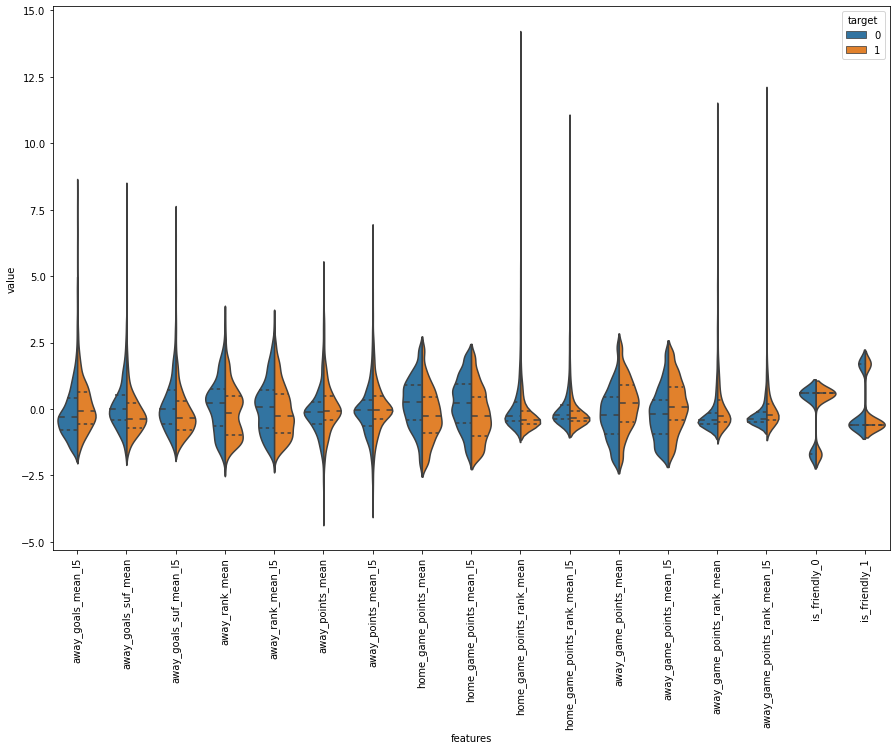

In [38]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

**ank difference is the only good separator of the data. But, we can create features that get the differences between home and away team and analyze if they are good separating the data.**

In [39]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

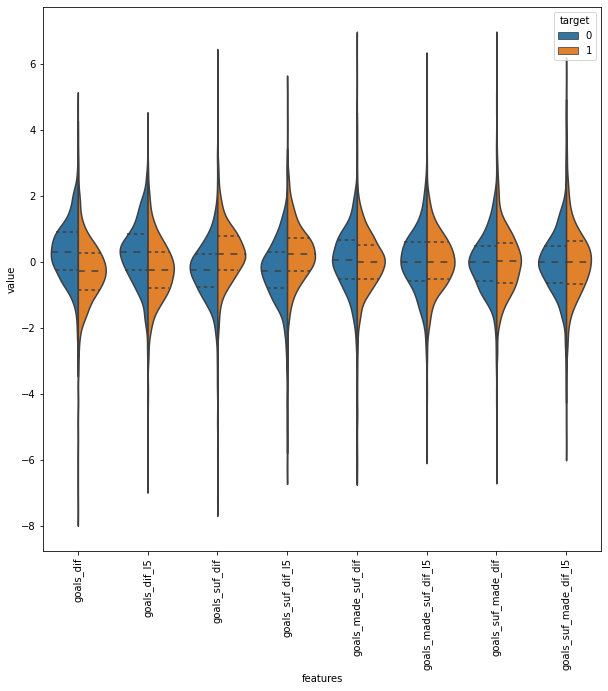

In [40]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

**goal differences are good separator, and goals suffered difference too. Differences between goals made and goals suffered of the teams are not very good separators**

**We can create other features, like differences of points made, differences of points made by rank faced and differences of rank faced.**

In [41]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [42]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

In [43]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

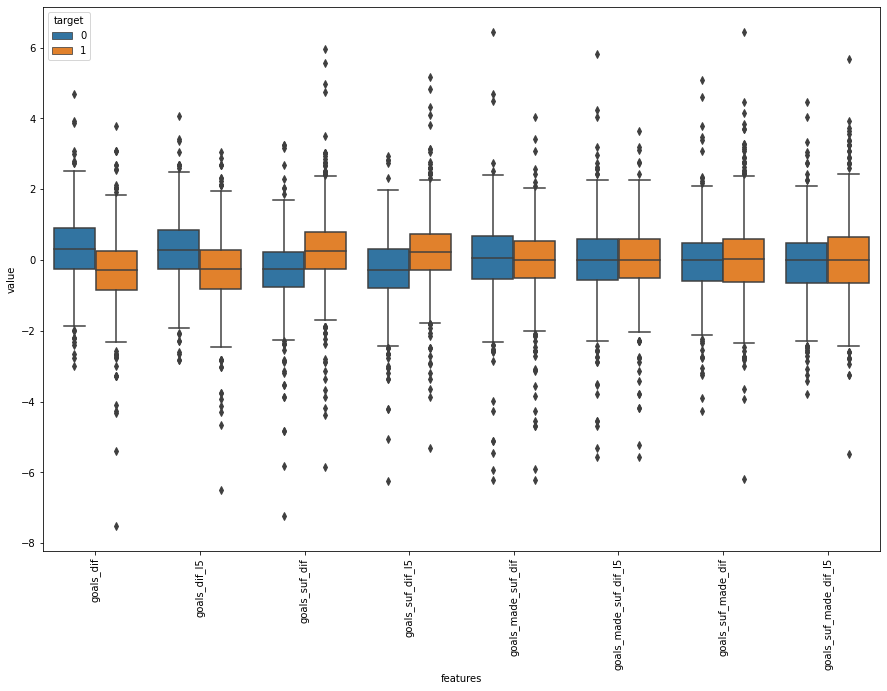

In [44]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

**final features are:**

1. rank_dif
2. goals_dif
3. goals_dif_l5
4. goals_suf_dif
5. goals_suf_dif_l5
6. dif_rank_agst
7. dif_rank_agst_l5
8. goals_per_ranking_dif
9. dif_points_rank
10. dif_points_rank_l5
11. is_friendly

In [45]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

# Modeling

In [46]:
model_db = create_db(df)

In [47]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [48]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.22, random_state=100)

In [50]:
gb = GradientBoostingClassifier(random_state=100)

params = {"learning_rate": [0.01, 0.02, 0.03],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [51]:
gb = gb_cv.best_estimator_
gb

GradientBoostingClassifier(learning_rate=0.03, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           random_state=100)

In [52]:
params_rf = {"max_depth": [25],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=100)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [25], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [53]:
rf = rf_cv.best_estimator_

In [54]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

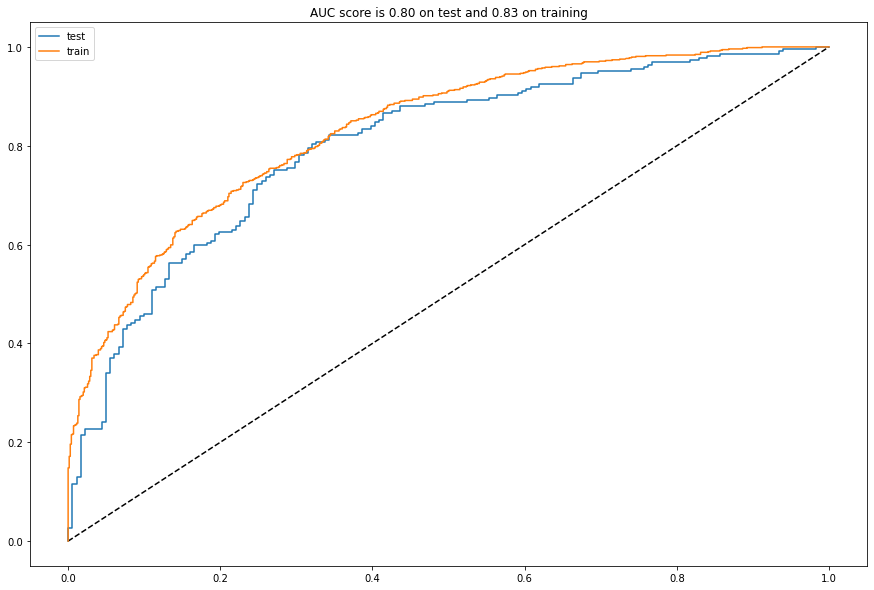

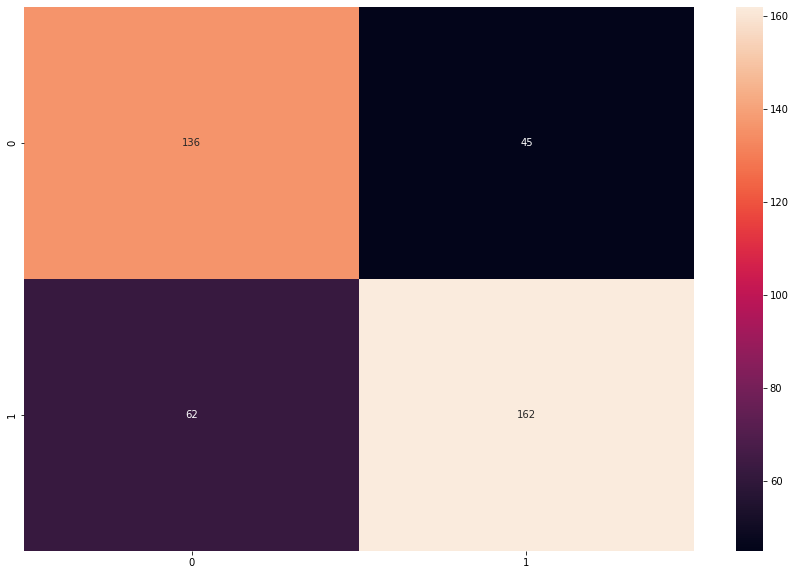

In [55]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")
analyze(gb)

So, we get 80% test accuracy that's very well

# Create Games

**Using Web Scraping into wikipedia**

In [56]:
from operator import itemgetter

In [57]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [58]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[11].iloc[:, 1].values)]

for i in range(12, 67, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

**use last game stats as the stats for each team involved in the game.**

In [59]:
def find_stats(team_1):
#team_1 = "Qatar"
    last_game = base_df[(base_df["home_team"] == team_1) | (base_df["away_team"] == team_1)].tail(1)

    if last_game["home_team"].values[0] == team_1:
        team_1_rank = last_game["rank_home"].values[0]
        team_1_goals = last_game["home_goals_mean"].values[0]
        team_1_goals_l5 = last_game["home_goals_mean_l5"].values[0]
        team_1_goals_suf = last_game["home_goals_suf_mean"].values[0]
        team_1_goals_suf_l5 = last_game["home_goals_suf_mean_l5"].values[0]
        team_1_rank_suf = last_game["home_rank_mean"].values[0]
        team_1_rank_suf_l5 = last_game["home_rank_mean_l5"].values[0]
        team_1_gp_rank = last_game["home_game_points_rank_mean"].values[0]
        team_1_gp_rank_l5 = last_game["home_game_points_rank_mean_l5"].values[0]
    else:
        team_1_rank = last_game["rank_away"].values[0]
        team_1_goals = last_game["away_goals_mean"].values[0]
        team_1_goals_l5 = last_game["away_goals_mean_l5"].values[0]
        team_1_goals_suf = last_game["away_goals_suf_mean"].values[0]
        team_1_goals_suf_l5 = last_game["away_goals_suf_mean_l5"].values[0]
        team_1_rank_suf = last_game["away_rank_mean"].values[0]
        team_1_rank_suf_l5 = last_game["away_rank_mean_l5"].values[0]
        team_1_gp_rank = last_game["away_game_points_rank_mean"].values[0]
        team_1_gp_rank_l5 = last_game["away_game_points_rank_mean_l5"].values[0]
    
    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [60]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

# Predicting

In [61]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]
print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))




---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.67 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.62 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.64 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.74 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.76 probability


Group A advanced: 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.69 probability
Group B - United States vs. Wales: Winner United States with 0.53 probability
Group B - Wales vs. Iran: Draw
Group B - England vs. United States: Draw
Group B - Wales vs. England: Winner England with 0.66 probability
Group B - Iran vs. United States: Draw


Group B advanced: 
England -------- 7
United States -------- 5
Iran --------

In [62]:
advanced = advanced_group
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [63]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])
        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: United States advances with prob 0.52
Argentina vs. France: Argentina advances with prob 0.50
Spain vs. Croatia: Spain advances with prob 0.51
Brazil vs. Uruguay: Brazil advances with prob 0.63
Senegal vs. England: England advances with prob 0.70
Mexico vs. Denmark: Denmark advances with prob 0.59
Germany vs. Belgium: Belgium advances with prob 0.51
Switzerland vs. Portugal: Portugal advances with prob 0.53
----------
Starting simulation of Quarter-Final
----------


United States vs. Argentina: Argentina advances with prob 0.62
Spain vs. Brazil: Brazil advances with prob 0.59
England vs. Denmark: Denmark advances with prob 0.52
Belgium vs. Portugal: Portugal advances with prob 0.54
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Argentina advances with prob 0.52
Denmark vs. Portugal: Portugal advances with prob 0.53
----------
Starting simulation of Final
---------

# Visualize the Results

In [64]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

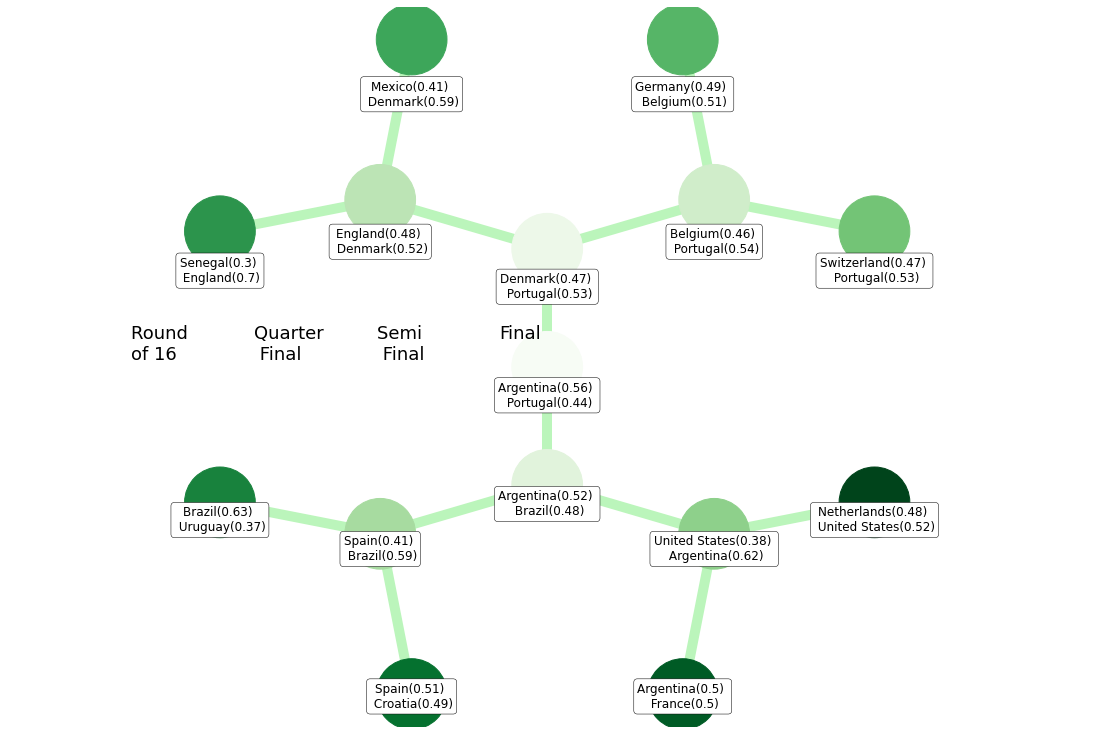

In [65]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()